# Causal delay propagation in the US airport network 
This notebook contains an exploratory analysis of the US airport and fligt network, specifically the delays, network structure and causality in delay propagation in the network. Delays can be caused by spurious events that are hard to predict or prepare for, for example weather. We may also think that delays cause further delays, i.e. they propagate through the network over time and over flights, from airport to airport. Also, a departure delay may cause the flight to not to be allowed to land the designated time, which will cause further delays up to a limit, due to the amount of fuel an airplane can carry. In this analysis we focus on delay propagation in the network, and try to show not only correlations, but causality. The flight data used for this analysis come from the TranStats data library (http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) and contains all flight data from August 2016, and contains 4.9 million flights.


## Summary of conclusions
We find that there is a causal propagation of delays in the US airport network for the time period analysed. Especially, when looking closer at the 20 busiest airports, the LGA airport stands out, suffering from delay propagation from 9 other airport. The airport propagating delay to most other airports is the ATL airport that propagates delays to 10 airports, that in turn propagate them to LGA. There may be several explanations for this, but one could be that LGA is continuously operating at its maximum capacity and is thus not able to mitigate extreme delays.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import numpy as np

from matplotlib import colors
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

%matplotlib inline

/Users/23056164/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load, clean and prepare data

In [9]:
# Load time and delay data
flights = (pd
           .read_csv('On_Time_On_Time_Performance_2016_8.csv'
                     , sep = ','
                     , usecols = ['FlightDate', 'CRSDepTime', 'DepTime', 'ArrTime', 'DepDelayMinutes']
                     , parse_dates = {'timestamp':[0,1]}
                     , infer_datetime_format = True
                     , na_values = ''
                     , dtype = {'DepTime': str, 'ArrTime': str}
                    )
           .rename(columns=str.lower)
    ).dropna() # without domain knowledge how to handle NaNs, we have to drop them

In [10]:
# Load additional data. 
# Necessary since parsing would work with all columns at once, 
# due to some departure times have the value 2400, which is not a vlaid strptime
flights2 = (pd
           .read_csv('On_Time_On_Time_Performance_2016_8.csv'
                     , sep = ','
                     , usecols = ['ArrDelayMinutes', 'DestAirportID', 'OriginAirportID', 'CRSDepTime', 'CRSArrTime']
                     , na_values = ''
                     , dtype = {'DestAirportID': str, 'OriginAirportID': str, 'CRSDepTime':str, 'CRSArrTime':str}
                    )
           .rename(columns=str.lower)
    ).dropna() # without domain knowledge how to handle NaNs, we have to drop them

In [4]:
f = pd.concat([flights,flights2], axis = 1) 

In [5]:
f.dropna(inplace=True)

In [6]:
f = f.set_index('timestamp')

In [7]:
f['depminuteofday'] = f.deptime.apply(lambda x: 1440 if x == '2400' else time.strptime(x,'%H%M').tm_hour*60 + time.strptime(x,'%H%M').tm_min)

In [8]:
f['crsdepminuteofday'] = f.crsdeptime.astype(str).apply(lambda x: 1440 if x == '2400' else time.strptime(x,'%H%M').tm_hour*60 + time.strptime(x,'%H%M').tm_min)

In [9]:
f.depdelayminutes = f.depdelayminutes.astype(int)
f.arrdelayminutes = f.arrdelayminutes.astype(int)

In [10]:
f = f.sort_index()

## Exploratory analysis
Now, that we have prepared data, let's first look at some scatter plots and distributions of the delays.

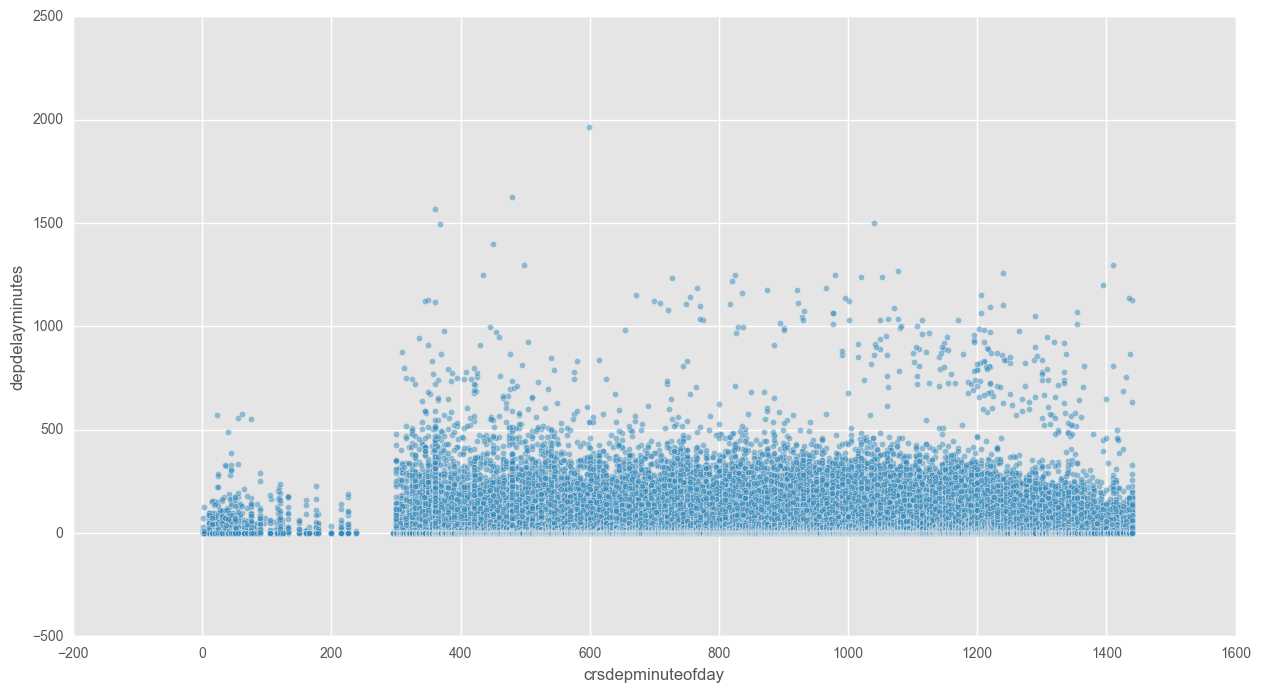

In [11]:
f.plot(kind = 'scatter', x = 'crsdepminuteofday', y = 'depdelayminutes', figsize = (15,8), alpha = 0.5);

The scatter plot above of the departure delays (in minutes) vs the scheduled departure minute of the day, may tell us something about extreme values and outliers. We can see that delays start in the morning (minute 300) and most of them are below 500 minutes, but some rise up to three times this. There is also a set of longer delays that start appearing later in the day, and a band above the 500 minutes, where only a few delays exist. There is no obvious explanation for this, and should be explored further. For this, domain knowledge is probably needed, so we will not do this now. After midnight, the delays slowly disappear.

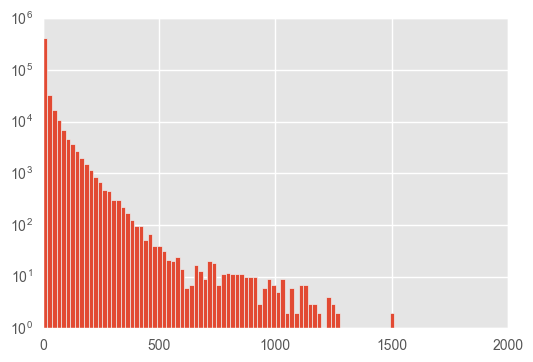

In [12]:
f.depdelayminutes.hist(bins = 100, log = True);

The histogram of departure delay above shows that there is something special going on at around 600 minutes (10 hours), which confirm the band in the scatter plot above. A potential hypothesis is that flights usually get cancelled when this limit is reached Beyond that limit the distribution looks different, so some other underlying dynamic is at work.

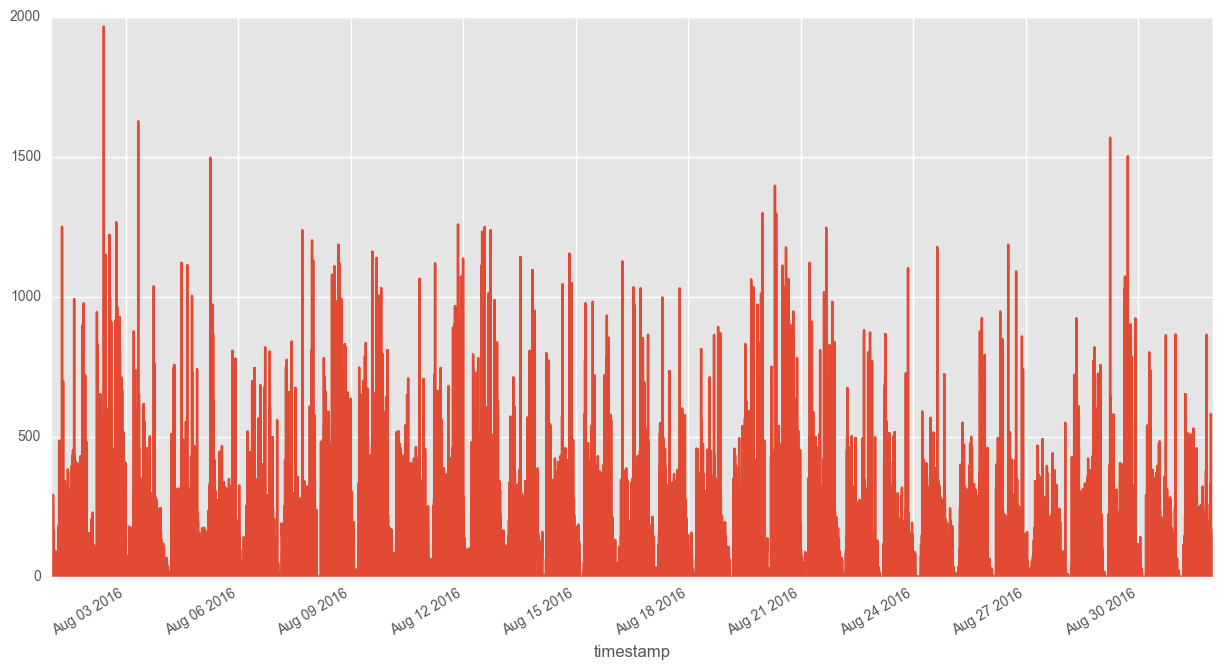

In [13]:
f.depdelayminutes.plot(figsize = (15,8));

The plot above shows delays as they occur over the month of August 2016, by the minute. It is obvious that there is a daily cycle, during which the delays disappear at midnight.

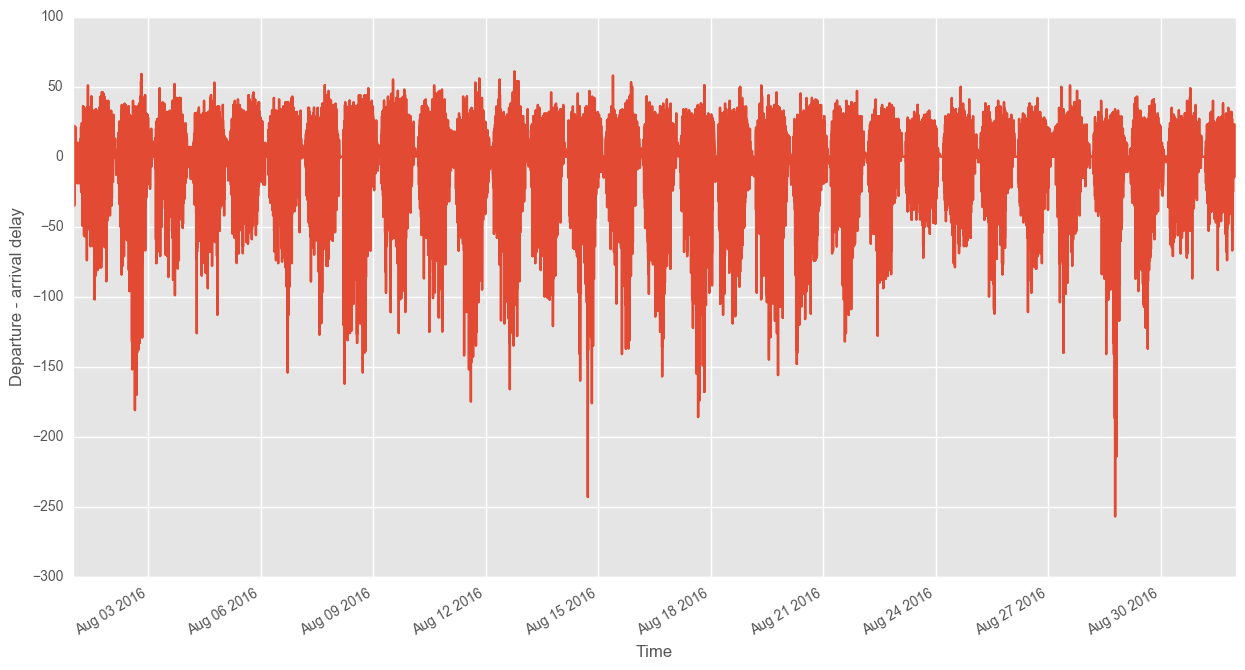

In [14]:
ax = (f.depdelayminutes - f.arrdelayminutes).plot(figsize = (15,8));
plt.ylabel('Departure - arrival delay')
plt.xlabel('Time')
plt.show()

So what about the difference between departure delays and arrival delays for the same flights? In the plot above we see the difference for each fligth, and note that the difference is mostly negative. This is somewhat surprising. We would expect departure delayed flights to catch up and reduce arrival delay by increasing speed when in the air. However, departure delays can cause larger arrival delay due to congestion at arrival airport, and thus needing to circle until a slot is available.

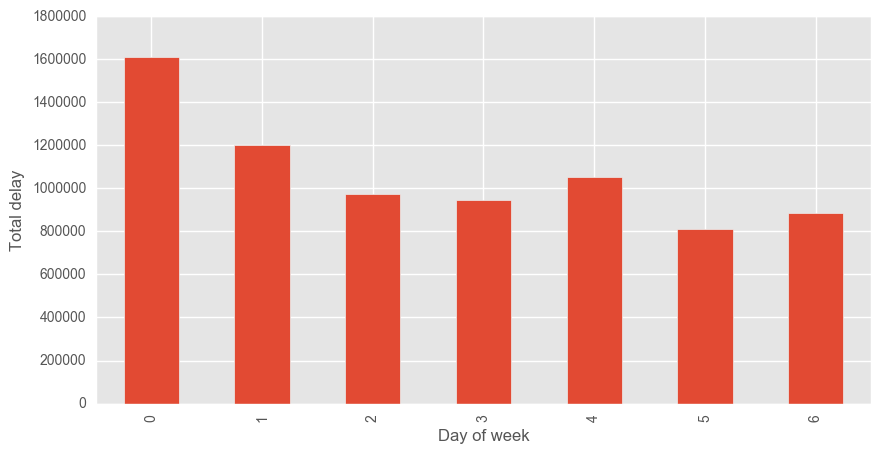

In [15]:
countdata = f.depdelayminutes.groupby(f.index.dayofweek).sum()
ax = countdata.plot(kind='bar', figsize=[10, 5])
plt.xlabel('Day of week')
plt.ylabel('Total delay')
plt.show() 

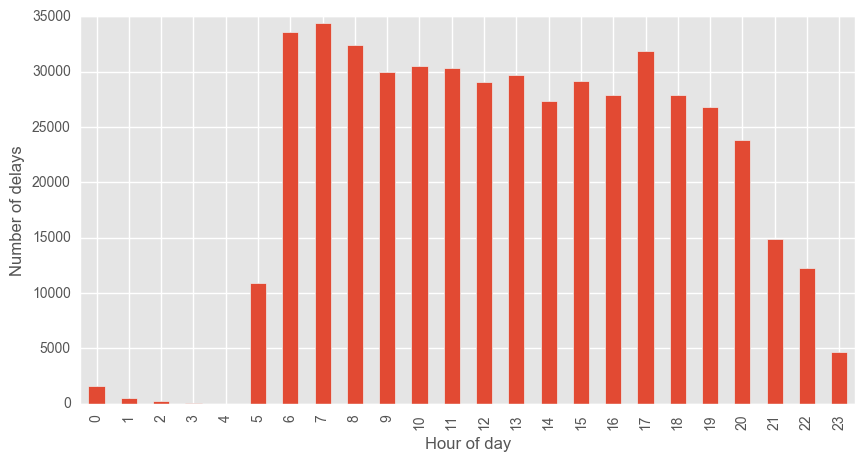

In [16]:
#number of flights per hour
countdata = f.destairportid.groupby(f.index.hour).size()
ax = countdata.plot(kind='bar', figsize=[10, 5])
plt.xlabel('Hour of day')
plt.ylabel('Number of delays')
plt.show()

The number of delays rise quickly in the morning hours, and keep steady until around 19 when they quickly drop.

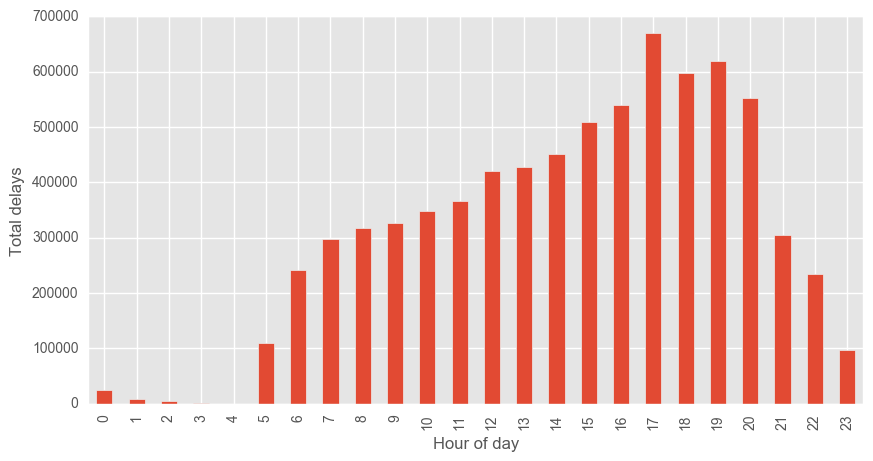

In [17]:
countdata = f.depdelayminutes.groupby(f.index.hour).sum()
ax = countdata.plot(kind='bar', figsize=[10, 5])
plt.xlabel('Hour of day')
plt.ylabel('Total delays')
plt.show() 

In contrast to the number of delays, the total delays (not cumulative) rise over the day and then also quickly drops at around 19. This suggest that delays accumulate over the day even if the number of delays do not, and can be an indication that delays propagate.

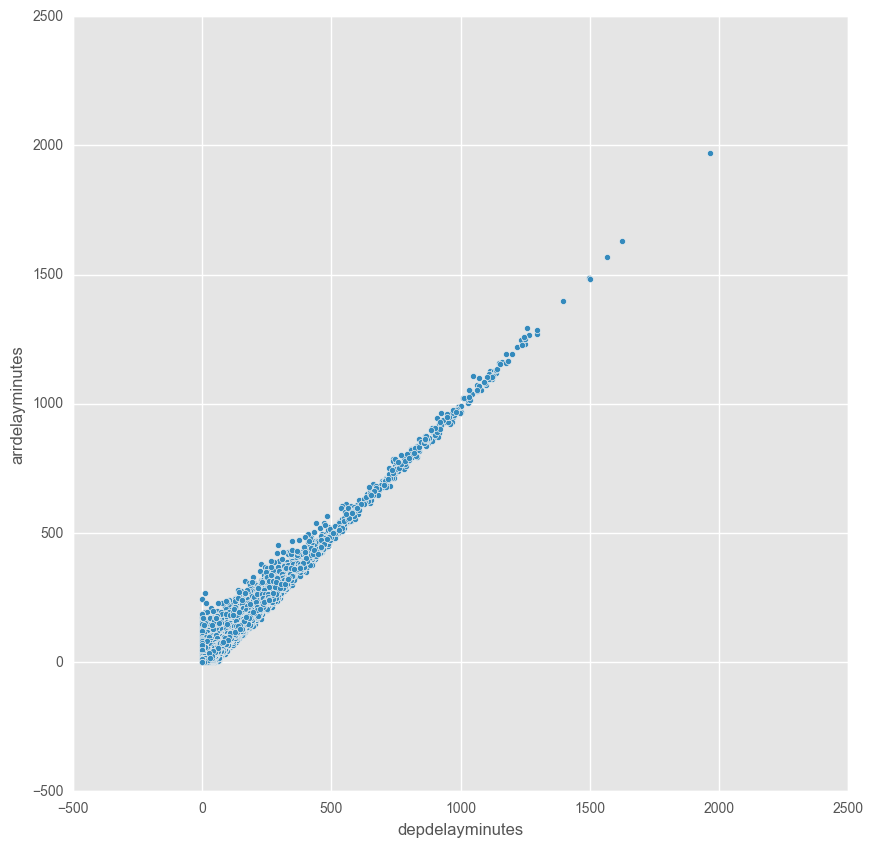

In [18]:
f.plot.scatter(x = 'depdelayminutes', y = 'arrdelayminutes', figsize=(10, 10));

Ploting arrival delays against departure delays does not reveal any surprises. We would expect a linear dependence and so seems to be the case. We will not delve deeper into this here.

In conclusion, the initial exploratory analysis suggests that delays have a complex underlying dynamic, and that an hypothesis stating that delays are causally propagated in the network is not completely unfeasible.

### Causality in propagation of extreme delays in airport network at high resolution

We will now take a closer look at delay propagation, by applying a recently proposed causality metric to arrival delays at their destination airports. The metric was proposed by M. Zanin in the paper "On causality of extreme events" (2015) (https://peerj.com/articles/2111/) and applied by Belkoura and Zanin to an analysis of European airport nework in the paper "Phase changes in delay propagation networks"(2016) (https://arxiv.org/abs/1611.00639) presented at ICRAT 2016. Compared to other causality metrics, for example Granger causality, it has the advantage of being applicable to non-linear data, as well as being able to detect confounding factors, and put less constraints on temporal aspects. First, let's look at the delays per airport.

In [19]:
fbyairport = f.groupby(f.destairportid)

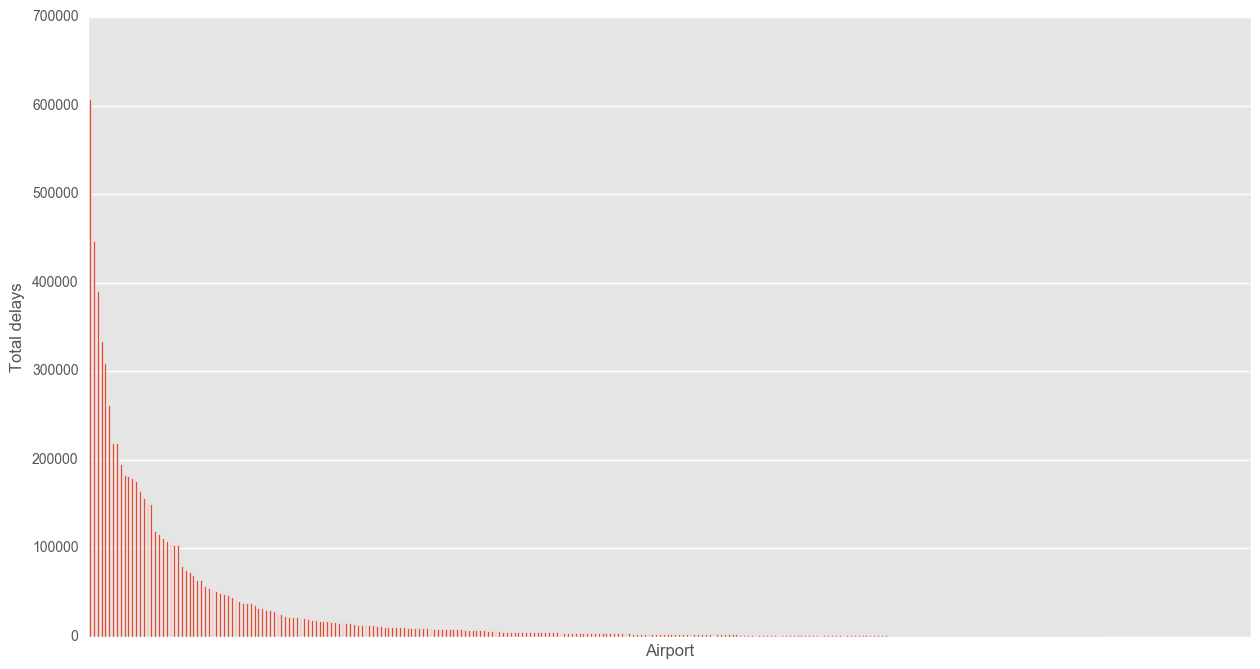

In [22]:
arrdelaysbyairport = fbyairport.arrdelayminutes.sum().sort_values(ascending = False)
ax = arrdelaysbyairport.plot(kind = 'bar',legend = False, figsize =(15,8));
plt.xlabel('Airport')
plt.ylabel('Total delays')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.show()

As expected, there is a huge difference in the total delays per airport.

Now, create a time series of average delays over a one hour timew indow, by downsampling and treating each airport as a separate time series.

In [23]:
dailydelays = f[['arrdelayminutes', 'destairportid']].pivot_table(index = f.index,columns = 'destairportid', values = 'arrdelayminutes').resample('1H').mean().fillna(0)

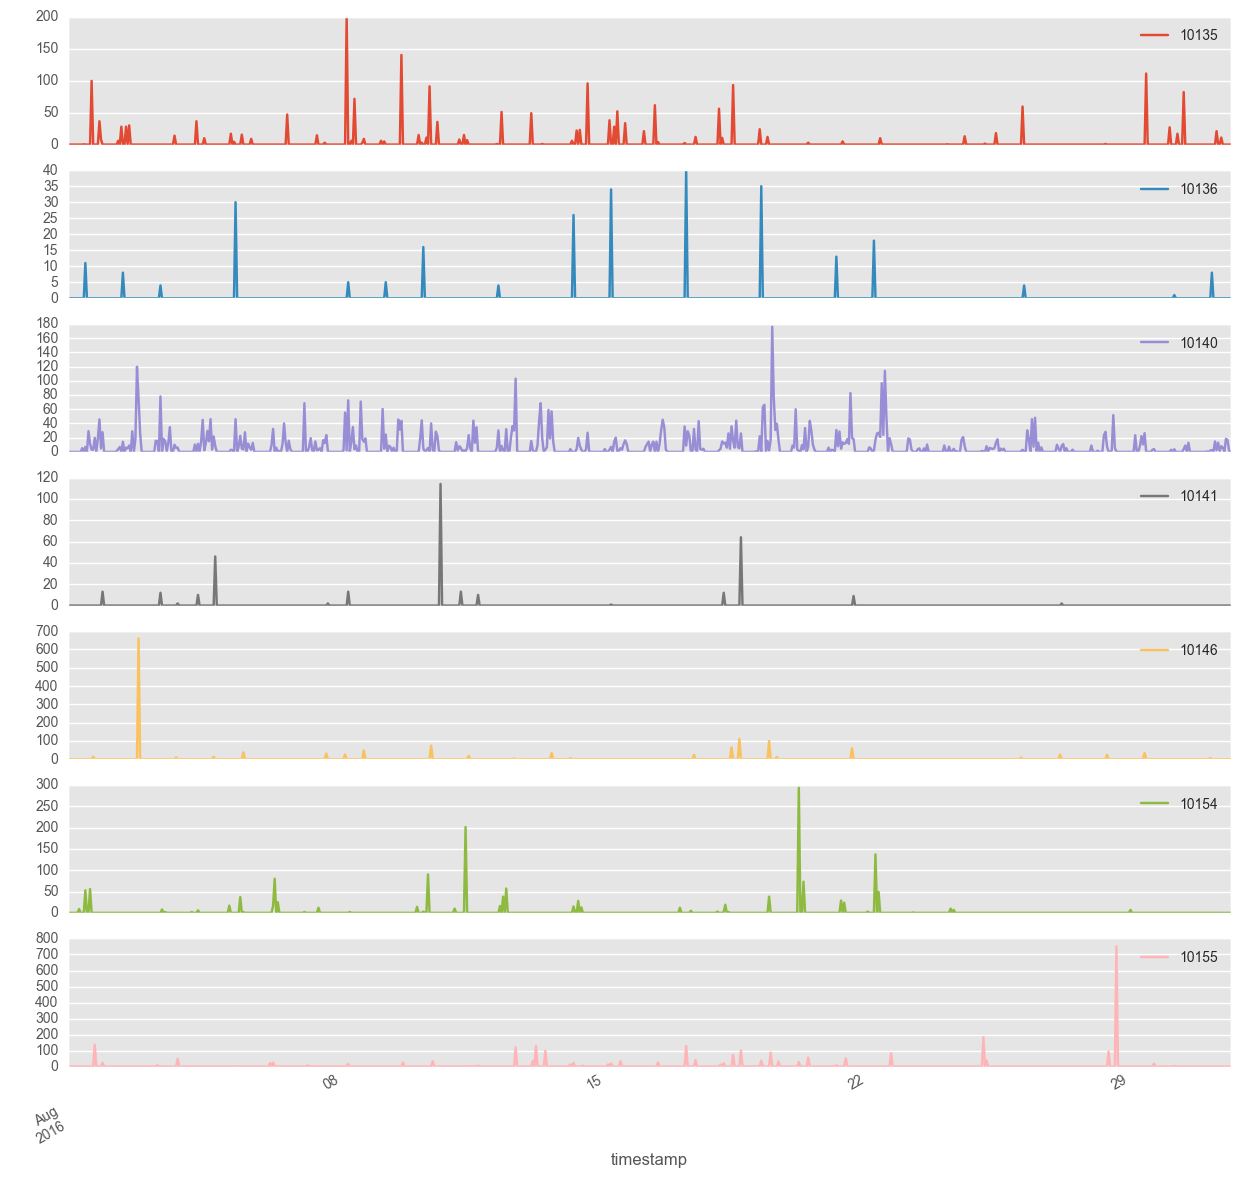

In [24]:
dailydelays[['10135','10136','10140','10141','10146','10154','10155']].plot(subplots = True, figsize = (15,15));

If we check a few of the individual delay time series per airport, we can see they make some sense, and that they are quite different in behavior and amplitude.

### Stationarity
Next, we need to check if the individual time series are stationary.

In [25]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(dailydelays.mean(axis = 1), autolag='AIC')
adfoutput = pd.Series(adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf[4].items():
    adfoutput['Critical Value (%s)'%key] = value
print adfoutput;

Test Statistic                  -2.464813
p-value                          0.124272
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (5%)             -2.865546
Critical Value (1%)             -3.439427
Critical Value (10%)            -2.568903
dtype: float64


Since p > 0.05 we fail to reject the null hypothesis that the mean delays series is non-stationary. However, what we want to know is really if each series is stationary.

In [26]:
i = (dailydelays.apply(lambda x: adfuller(x, autolag='AIC')[1]) < 0.05).to_frame()

In [27]:
i.columns = ['p']

In [28]:
i[~i['p']]

,p
destairportid,
10245,False
11298,False


So two series are not stationary. Let's have a closer look.

In [29]:
dailydelays['10245'].describe()

count    744.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 10245, dtype: float64

The first one had no flights at all, so there is nothing we can or need to do to it.

In [30]:
dailydelays['11298'].describe()

count    744.000000
mean      21.873434
std       35.299902
min        0.000000
25%        2.566176
50%       10.374735
75%       25.714686
max      280.846154
Name: 11298, dtype: float64

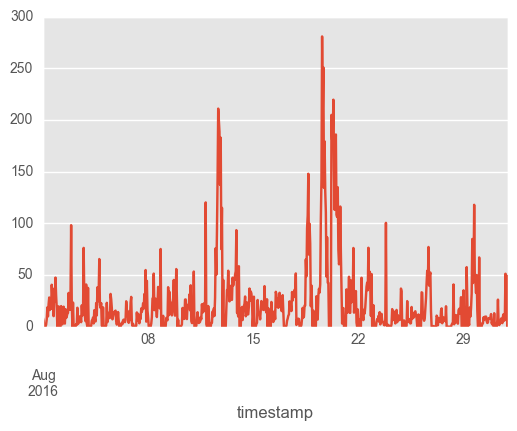

In [31]:
dailydelays['11298'].plot();

In [32]:
adf = adfuller(dailydelays['11298'], autolag='AIC')
adfoutput = pd.Series(adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf[4].items():
    adfoutput['Critical Value (%s)'%key] = value
print adfoutput;

Test Statistic                  -2.810232
p-value                          0.056827
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (5%)             -2.865546
Critical Value (1%)             -3.439427
Critical Value (10%)            -2.568903
dtype: float64


So the second series has a p-value slightly higher than 0.05, and a test statistic very close to the 5% critical value. So we are not far off. But we can make the second series stationary by exponentially weighted averages.

In [ ]:
expwighted_avg = pd.ewma(dailydelays['11298'], halflife=0.5)

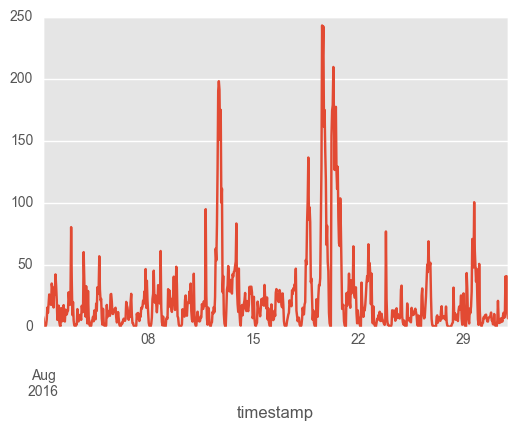

In [34]:
expwighted_avg.plot()

In [35]:
adf = adfuller(expwighted_avg, autolag='AIC')
adfoutput = pd.Series(adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf[4].items():
    adfoutput['Critical Value (%s)'%key] = value
print adfoutput;

Test Statistic                  -2.872067
p-value                          0.048694
#Lags Used                      19.000000
Number of Observations Used    724.000000
Critical Value (5%)             -2.865540
Critical Value (1%)             -3.439414
Critical Value (10%)            -2.568900
dtype: float64


The averaged series has a p-value < 0.05, so it is stationary.

In [36]:
dailydelays['11298'] = expwighted_avg

In order to get an overview of the daily delays, make a heatmap.

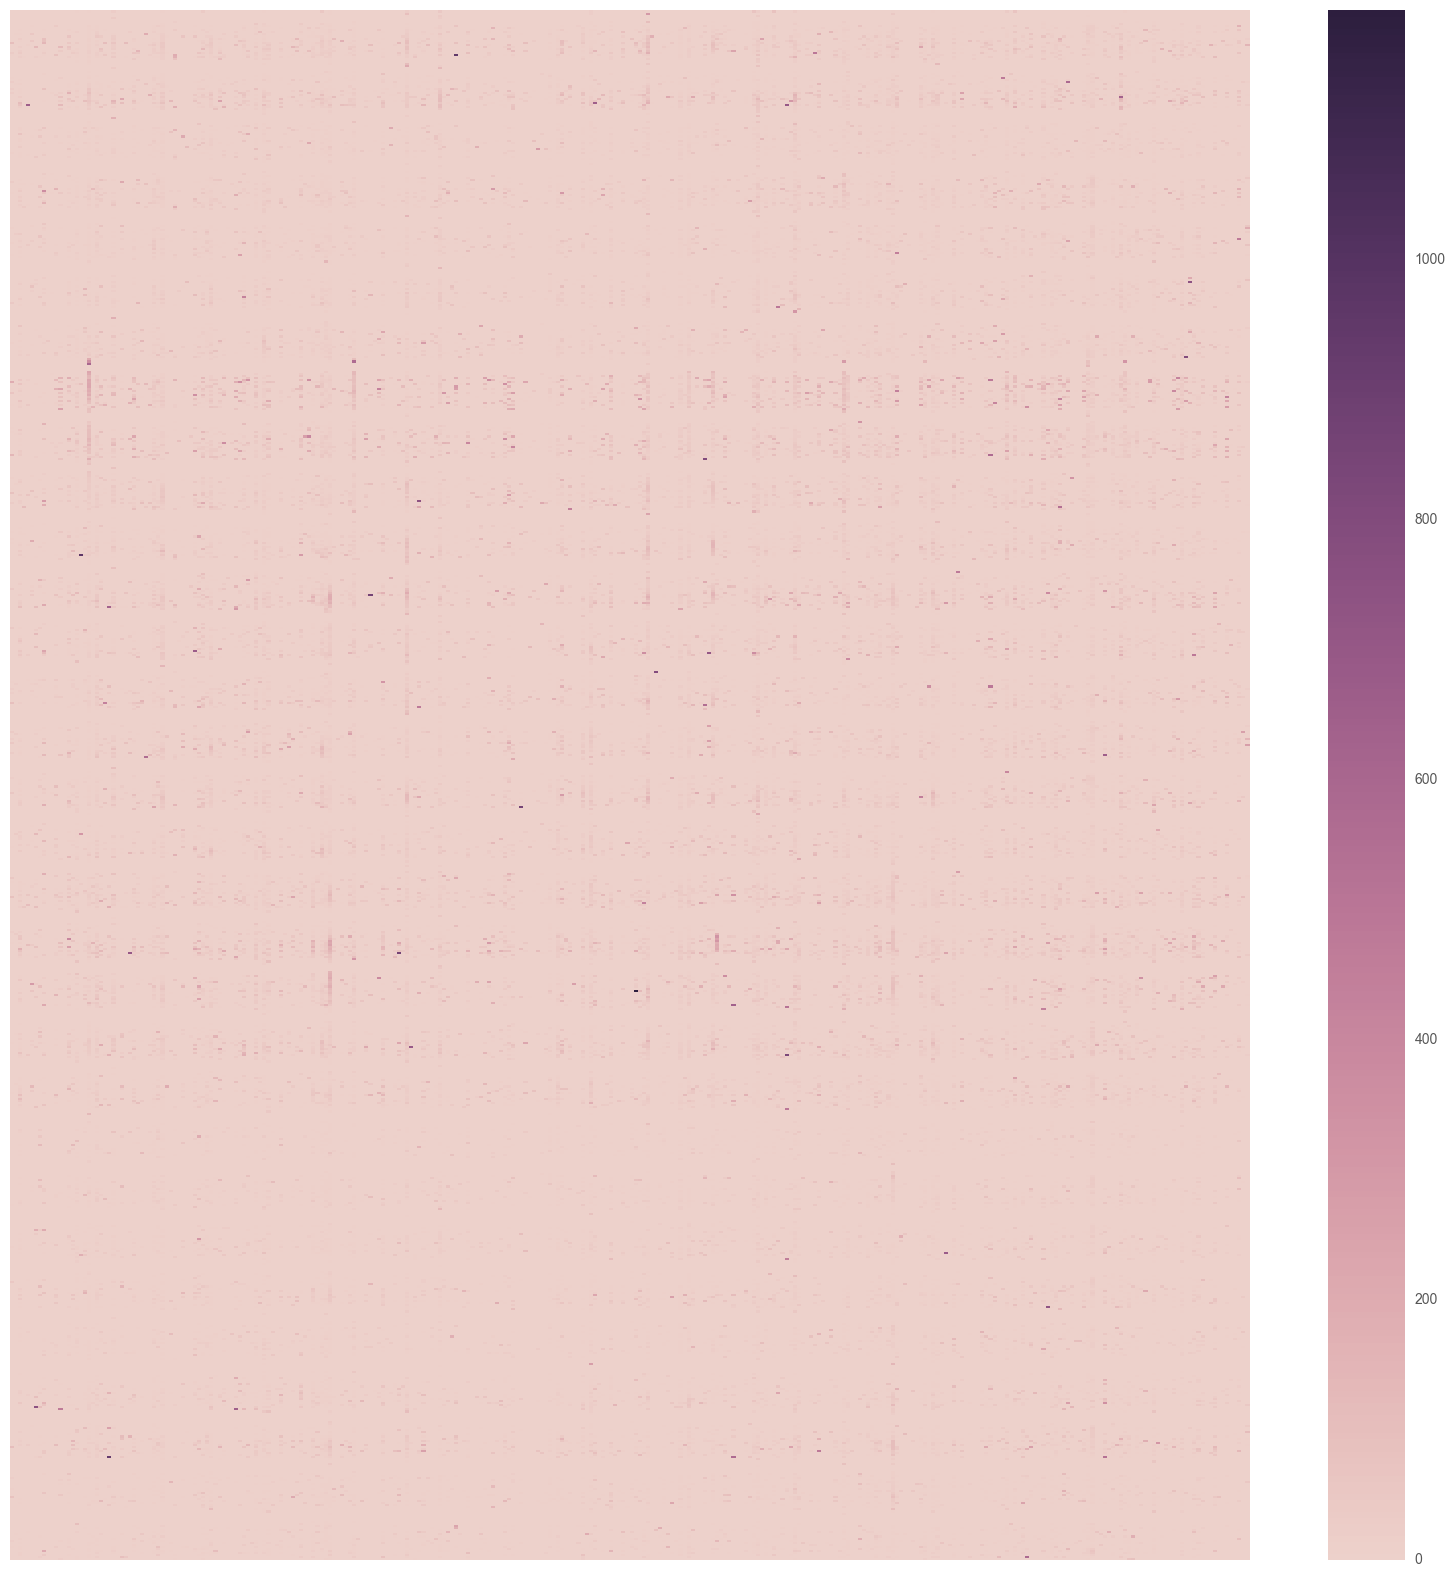

In [37]:
plt.rcParams['figure.figsize'] = (20, 20)
cmap = sns.cubehelix_palette(as_cmap=True)
ax = sns.heatmap(dailydelays, cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In the heatmap we see that there are horizontal(time) and vertical(airports) strands of small delays, punctuated in various places by dark black dots (extreme delays). 

## Causality
To determine causality in delay propagation we will use the causality metric for non-linear extreme events recently proposed by M. Zanin.

In [38]:
# code by M. Zanin, available from http://www.mzanin.com/

def TwoVectorsComparison(orV1, orV2):
    
    import numpy
    import scipy.special
    
    V1 = numpy.array( orV1 )
    meanV1 = V1.mean()
    maxV1 = V1.max()
    
    V2 = numpy.array( orV2 )
    meanV2 = V2.mean()
    maxV2 = V2.max()
    
    bestPValue = 1.0
    bestThr1 = 0.0
    bestThr2 = 0.0
    
    for offset in xrange(100):        

        thr1 = meanV1 + (maxV1 - meanV1) * (offset / 100.0)
        thr2 = meanV2 + (maxV2 - meanV2) * (offset / 100.0)
        
        conditionV1 = numpy.greater_equal( V1, thr1 )
        conditionV2 = numpy.greater_equal( V2, thr2 )
        
        subset1 =  numpy.extract( conditionV2, V1 )
        subset2 =  numpy.extract( conditionV1, V2 )
                    
        N_12 = numpy.array( [subset1.size], dtype = 'd' )
        N_21 = numpy.array( [subset2.size], dtype = 'd' )
        
        if N_12 == 0 or N_21 == 0:
            continue
        
        p_1 = numpy.extract( numpy.greater_equal(subset1, thr1), subset1 ).size / float( N_12 )
        p_2 = numpy.extract( numpy.greater_equal(subset2, thr2), subset2 ).size / float( N_21 )
        
        if p_2 > p_1:
            continue
        
        p_j = float( ( numpy.extract( numpy.greater_equal(subset1, thr1), subset1 ).size + \
                numpy.extract( numpy.greater_equal(subset2, thr2), subset2 ).size ) / \
                ( N_12 + N_21 ) )
                
        
        TS = float( float(p_1 - p_2) / numpy.sqrt( p_j * (1.0 - p_j) * (1.0 / float( N_12 ) + 1.0 / float( N_21 )) ) )
        
        pValue = 1.0 - scipy.special.ndtr( TS )

        if pValue < bestPValue:
            bestPValue = pValue
            bestThr1 = thr1
            bestThr2 = thr2
                
    return (bestPValue, bestThr1, bestThr2)
    
def StaticCausality(orV1, orV2):
    
    import numpy
    
    bestPValue = 1.1    
    
    V1 = numpy.array( orV1 )
    V2 = numpy.array( orV2 )
    (bestPValue_AA, bestThr1_AA, bestThr2_AA) = TwoVectorsComparison(V1, V2)
    if bestPValue > bestPValue_AA:
        bestPValue = bestPValue_AA
        bestThr1 = bestThr1_AA
        bestThr2 = bestThr2_AA
        bestMethod = 0
        
    V1 = numpy.array( orV1 )
    V2 = numpy.array( orV2 )
    V1 = V1.mean() - V1
    (bestPValue_AA, bestThr1_AA, bestThr2_AA) = TwoVectorsComparison(V1, V2)
    if bestPValue > bestPValue_AA:
        bestPValue = bestPValue_AA
        bestThr1 = bestThr1_AA
        bestThr2 = bestThr2_AA
        bestMethod = 1
        
    V1 = numpy.array( orV1 )
    V2 = numpy.array( orV2 )
    V2 = V2.mean() - V2
    (bestPValue_AA, bestThr1_AA, bestThr2_AA) = TwoVectorsComparison(V1, V2)
    if bestPValue > bestPValue_AA:
        bestPValue = bestPValue_AA
        bestThr1 = bestThr1_AA
        bestThr2 = bestThr2_AA
        bestMethod = 2
        
    V1 = numpy.array( orV1 )
    V2 = numpy.array( orV2 )
    V1 = V1.mean() - V1
    V2 = V2.mean() - V2
    (bestPValue_AA, bestThr1_AA, bestThr2_AA) = TwoVectorsComparison(V1, V2)
    if bestPValue > bestPValue_AA:
        bestPValue = bestPValue_AA
        bestThr1 = bestThr1_AA
        bestThr2 = bestThr2_AA
        bestMethod = 3

    return (bestPValue, bestThr1, bestThr2, bestMethod)



In [39]:
def fu(df, v1):
    return df.apply(lambda v2: TwoVectorsComparison(v1, v2), axis = 0)

In [40]:
causalities = dailydelays.apply((lambda x:fu(dailydelays,x)), axis = 0)

In [41]:
import networkx as nx

In [42]:
m = causalities.apply(lambda x: x.apply(lambda y: y[0]<0.00001)).as_matrix()

In [43]:
g = nx.from_numpy_matrix(m, create_using=nx.DiGraph())

In [44]:
#remove confounding factors by iterating edges and check if there is a reciprocal edge
#build a new graph  that only has edges that are not reciprocal
nc = nx.DiGraph()
for (u,v) in g.edges_iter():
    if not g.has_edge(v,u):
        nc.add_edge(u,v)

We need to remove confounding factors, which in this case means we need to remove reciprocal directed edges. Reciprocal edges indicate that there is some unseen factor which seemingly cause delays to be propapgated between two nodes.

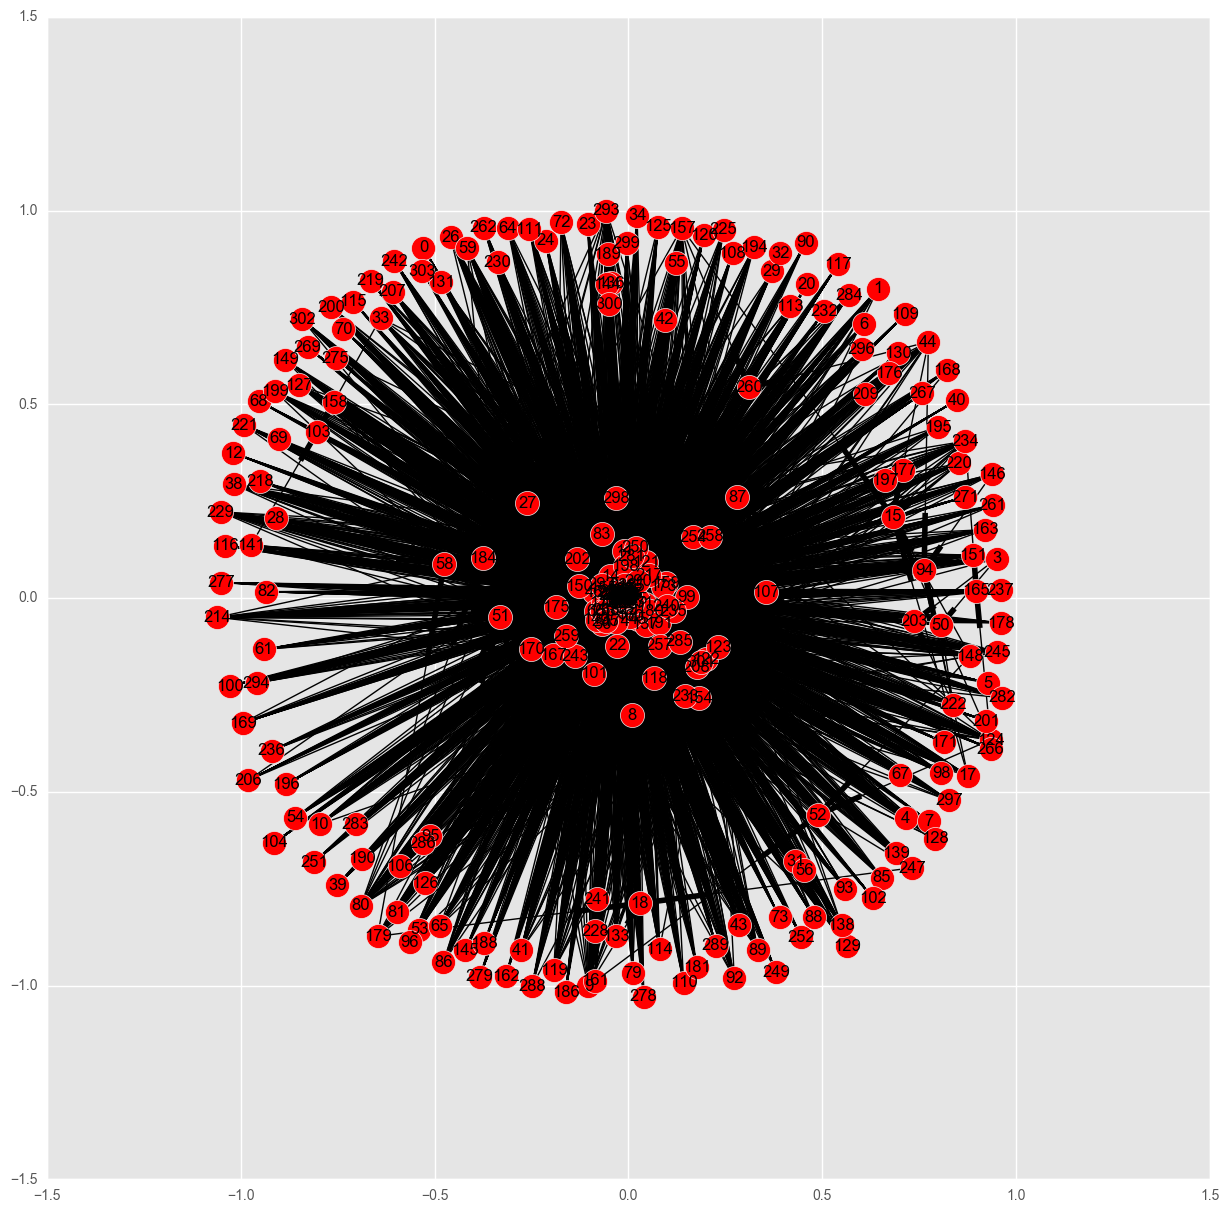

In [45]:
plt.rcParams['figure.figsize'] = (15, 15)
nx.draw_networkx(nc)

Usually, a "hairball" plot of a network doesn't tell us very much. But in this case, we can clearly see that there is a core of the network that the major part of the network connects to, which means that they propagate delays to this core.

From the "hairball" plot above it is hard to understand the structure, for example the degree distribution. Let's look closer.

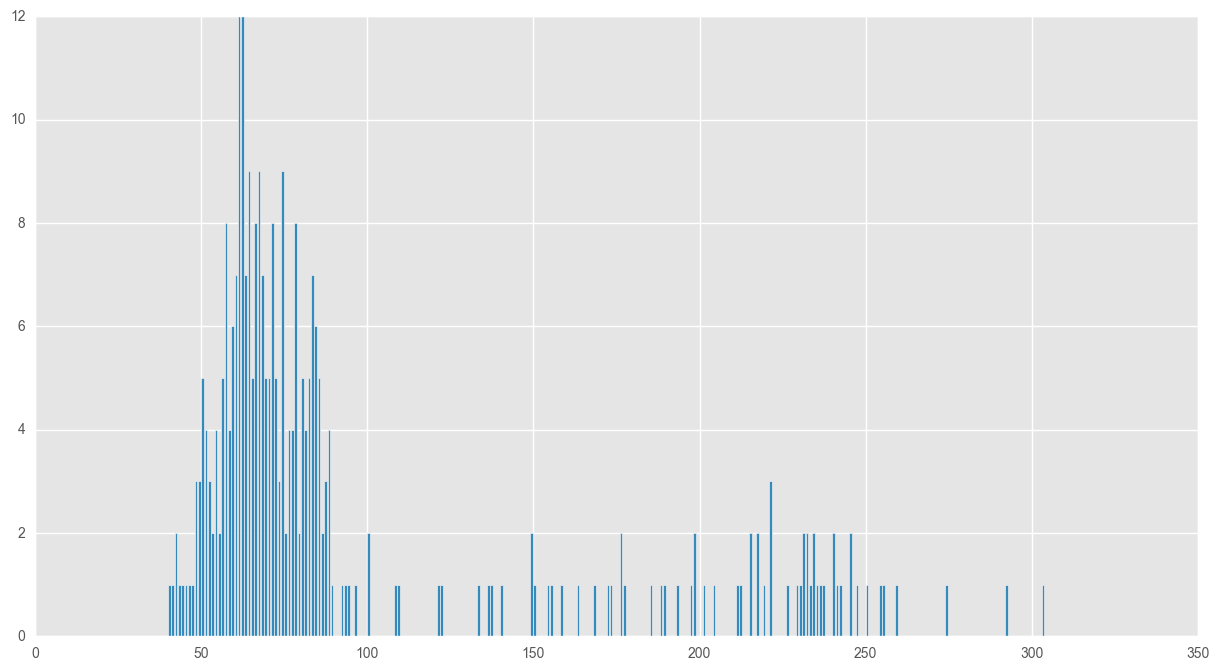

In [46]:
nx.degree_histogram(nc)
plt.rcParams['figure.figsize'] = (15, 8)
plt.bar(np.arange(len(nx.degree_histogram(nc))), nx.degree_histogram(nc));

In [47]:
np.median(nc.degree().values())

71.5

We see that the network is in general quite highly connected with an average degree of 72, but with some airports being connected to many more. This suggests a hub structure. 

## Closer look
In order to bettter understand what is going on, we focus on the 20 largest airport by number of flights

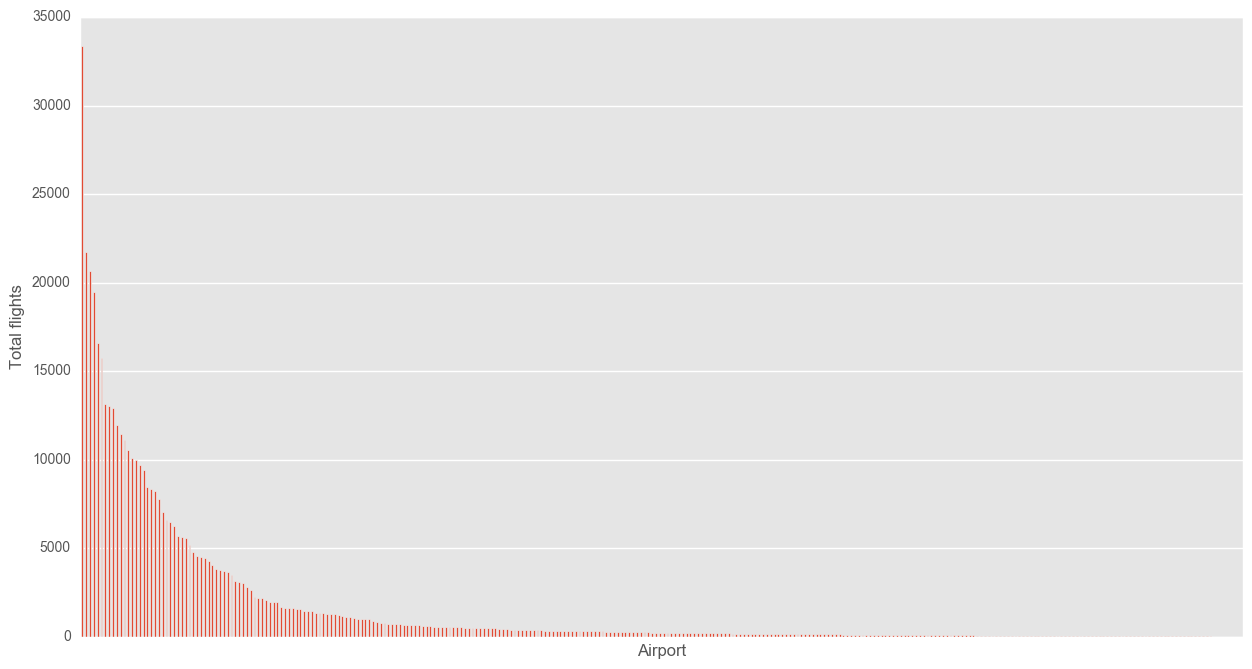

In [48]:
#number of flights per airport
airportsizes = f.destairportid.groupby(f.destairportid).size().sort_values(ascending = False)
#fig, ax = plt.subplots()
ax = airportsizes.plot(kind='bar', figsize=[15, 8])
plt.xlabel('Airport')
plt.ylabel('Total flights')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.show()

In [49]:
largestairports = airportsizes[airportsizes.values > 8000].keys()

In [50]:
dd = dailydelays.loc[:, list(dailydelays.columns.isin(largestairports))]

In [51]:
csl = dd.apply((lambda x:fu(dd,x)), axis = 0)

In [52]:
mm = csl.apply(lambda x: x.apply(lambda y: y[0]<0.0000001)).as_matrix()

In [53]:
gg = nx.from_numpy_matrix(mm, create_using=nx.DiGraph())

Load a mapping from airportIDs to Airport codes, e.g. LAX.

In [54]:
airports = (pd
           .read_csv('On_Time_On_Time_Performance_2016_8.csv'
                     , sep = ','
                     , usecols = ['Dest', 'DestAirportID']
                     , na_values = ''
                     , dtype = {'Dest': str, 'DestAirportID': str}
                    )
           .rename(columns=str.lower)
    ).dropna().drop_duplicates() # without domain knowledge how to handle NaNs, we have to drop them

In [55]:
airports.set_index('destairportid', inplace=True)
names = dict(airports.to_records())

In [56]:
z = zip(gg.nodes(),list(largestairports))
labels = {x:names[y][0:3] for x,y in z}

Plot the network using a spring layout.

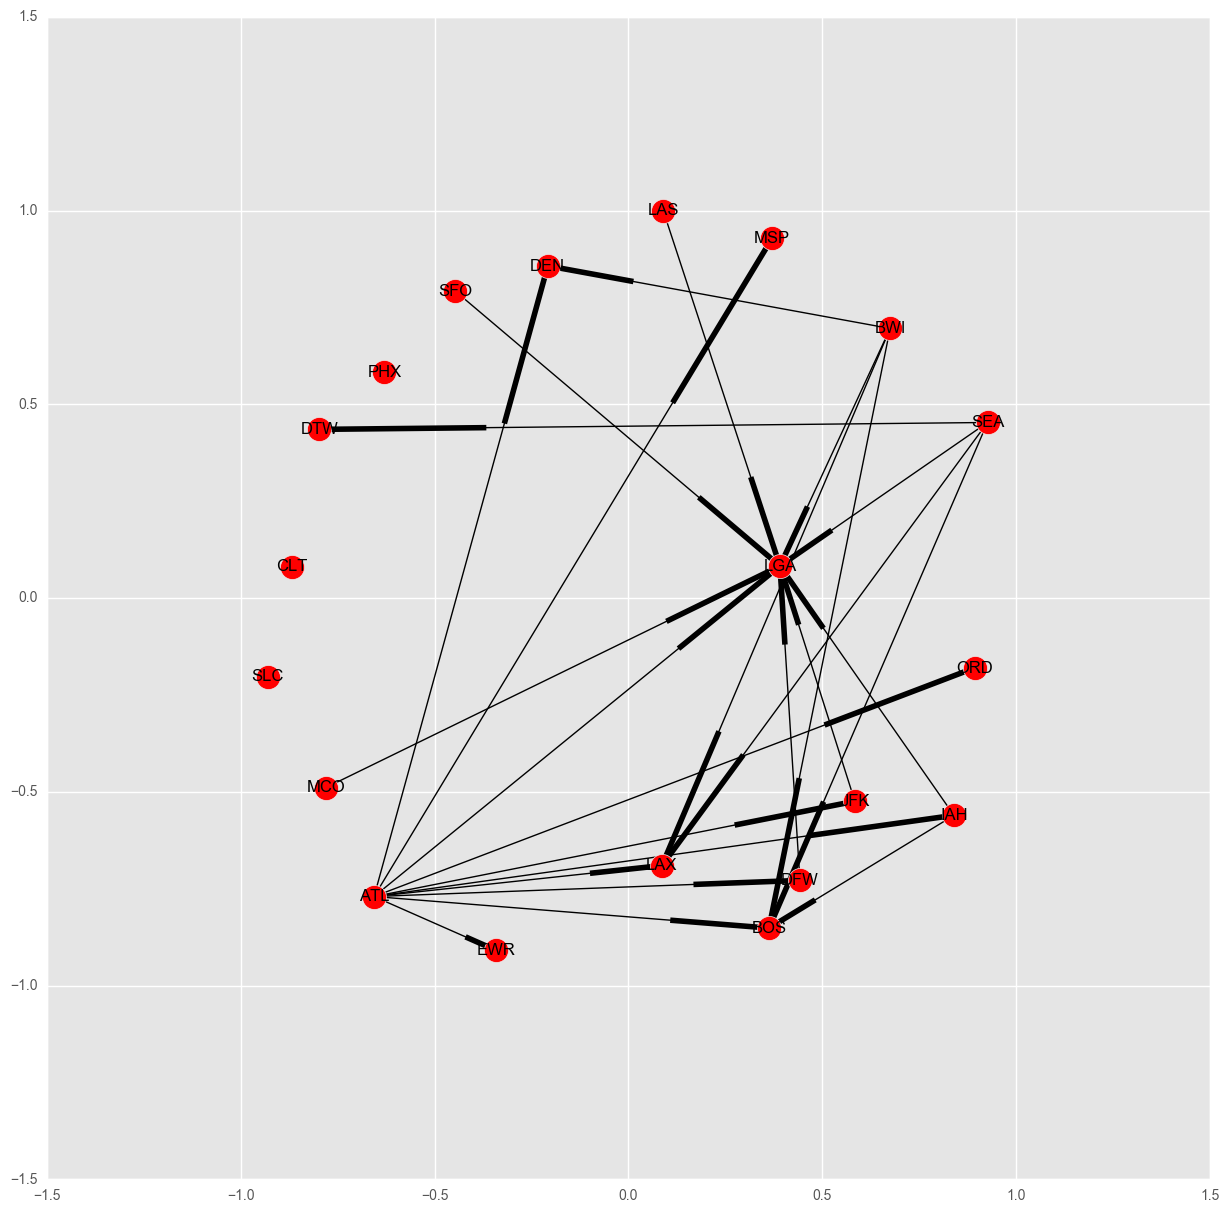

In [57]:
plt.rcParams['figure.figsize'] = (15, 15)
pos = nx.spring_layout(gg, k = 2)
nx.draw_networkx_nodes(gg,pos)
nx.draw_networkx_edges(gg,pos)
nx.draw_networkx_labels(gg,pos,labels);

## Conclusion
The LGA airport stands out, suffering from delay propagation from 9 other airport. The airport propagating delay to most other airports is the ATL airport that propagates delays to 10 airports, that in turn propagate them to LGA. There may be several explanations for this, but one could be that LGA is continuously operating at its maximum capacity and is thus not able to mitigate extreme delays.